In [1]:
import numpy as np
import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils
mpl_stylesheet.banskt_presentation(splinecolor = 'black')

import sys
sys.path.append('../penalty_optimization/')
import lagrangian_optim as lgopt
from scipy import optimize as sp_optimize
from scipy import interpolate as sp_interpolate

from mrashpen.models.normal_means_ash_scaled import NormalMeansASHScaled

### Generate data from Normal Means model

Sample $\mathbf{b}$ from a mixture of Gaussians, and sample $\mathbf{y}$ from the multivariate Gaussian $N_n(\mathbf{b}, \mathbb{I}_n)$, where $\mathbb{I}_n$ is the $n \times n$ identity matrix.

$\mathbf{b} \sim \sum_{k = 1}^{K}w_k N(0, \sigma_k^2)$

$\mathbf{y} \sim N_n(\mathbf{\mu}, \mathbb{I}_n)$,

where $n$ is the number of samples.
The posterior probability $\hat{q}(\mathbf{b} \mid \mathbf{y}, w_1, \ldots, w_K, \sigma_1, \ldots, \sigma_K)$ is obtained analytically (using Eq. 26 and 27 of [this document](https://www.overleaf.com/project/60d0d9301e098e4dbe8e3521)).
We also calculate the posterior mean $\mathbf{b}^{*} \triangleq \mathbb{E}_{\hat{q}}[\mathbf{b}]$. 

In [2]:
def sample_mixgauss(wk, sk, size):
    runif = np.random.uniform(0, 1, size = size)
    gcomp = np.digitize(runif, np.cumsum(wk))
    x = np.zeros(size)
    for i, gc in enumerate(gcomp):
        if sk[gc] > 0:
            x[i] = np.random.normal(0, sk[gc]) 
    return x

def NM_sample(mean, std = 1.0):
    p   = mean.shape[0]
    cov = np.eye(p) * std * std
    y   = np.random.multivariate_normal(mean, cov)
    return y

def initialize_ash_prior(k, scale = 2, sparsity = None):
    w = np.zeros(k)
    w[0] = 1 / k if sparsity is None else sparsity
    w[1:(k-1)] = np.repeat((1 - w[0])/(k-1), (k - 2))
    w[k-1] = 1 - np.sum(w)
    sk2 = np.square((np.power(scale, np.arange(k) / k) - 1))
    prior_grid = np.sqrt(sk2)
    return w, prior_grid

In [3]:
p = 500
k = 4
sparsity = 0.9
strue = 1.0

np.random.seed(100)
wtrue, sk = initialize_ash_prior(k, sparsity = sparsity, scale = 10.0)
#sk = np.logspace(-1, k-2, k)
btrue = sample_mixgauss(wtrue, sk, p)
y = NM_sample(btrue, std = strue)
print ("Standard deviation of prior mixture components: "
       + ', '.join([f"{x:.3f}" for x in sk])
      )
print ()

dj = np.ones(p)
nmash = NormalMeansASHScaled(y, strue, wtrue, sk, d = dj)
qphi, qmu, qvar = nmash.posterior()

bpostmean = np.sum(qphi * qmu, axis = 1)
wpost = np.sum(qphi, axis = 0)
wpost = wpost / np.sum(wpost)

Standard deviation of prior mixture components: 0.000, 0.778, 2.162, 4.623

2022-03-28 17:19:40,648 | mrashpen.models.normal_means_ash_scaled | DEBUG | Calculating posterior for NM model.


In [4]:
bconst = bpostmean.copy()

Minv = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'hybr')
theta_newraph = Minv.x
b_newraph = lgopt.shrink_theta(theta_newraph, strue, wpost, sk, dj)

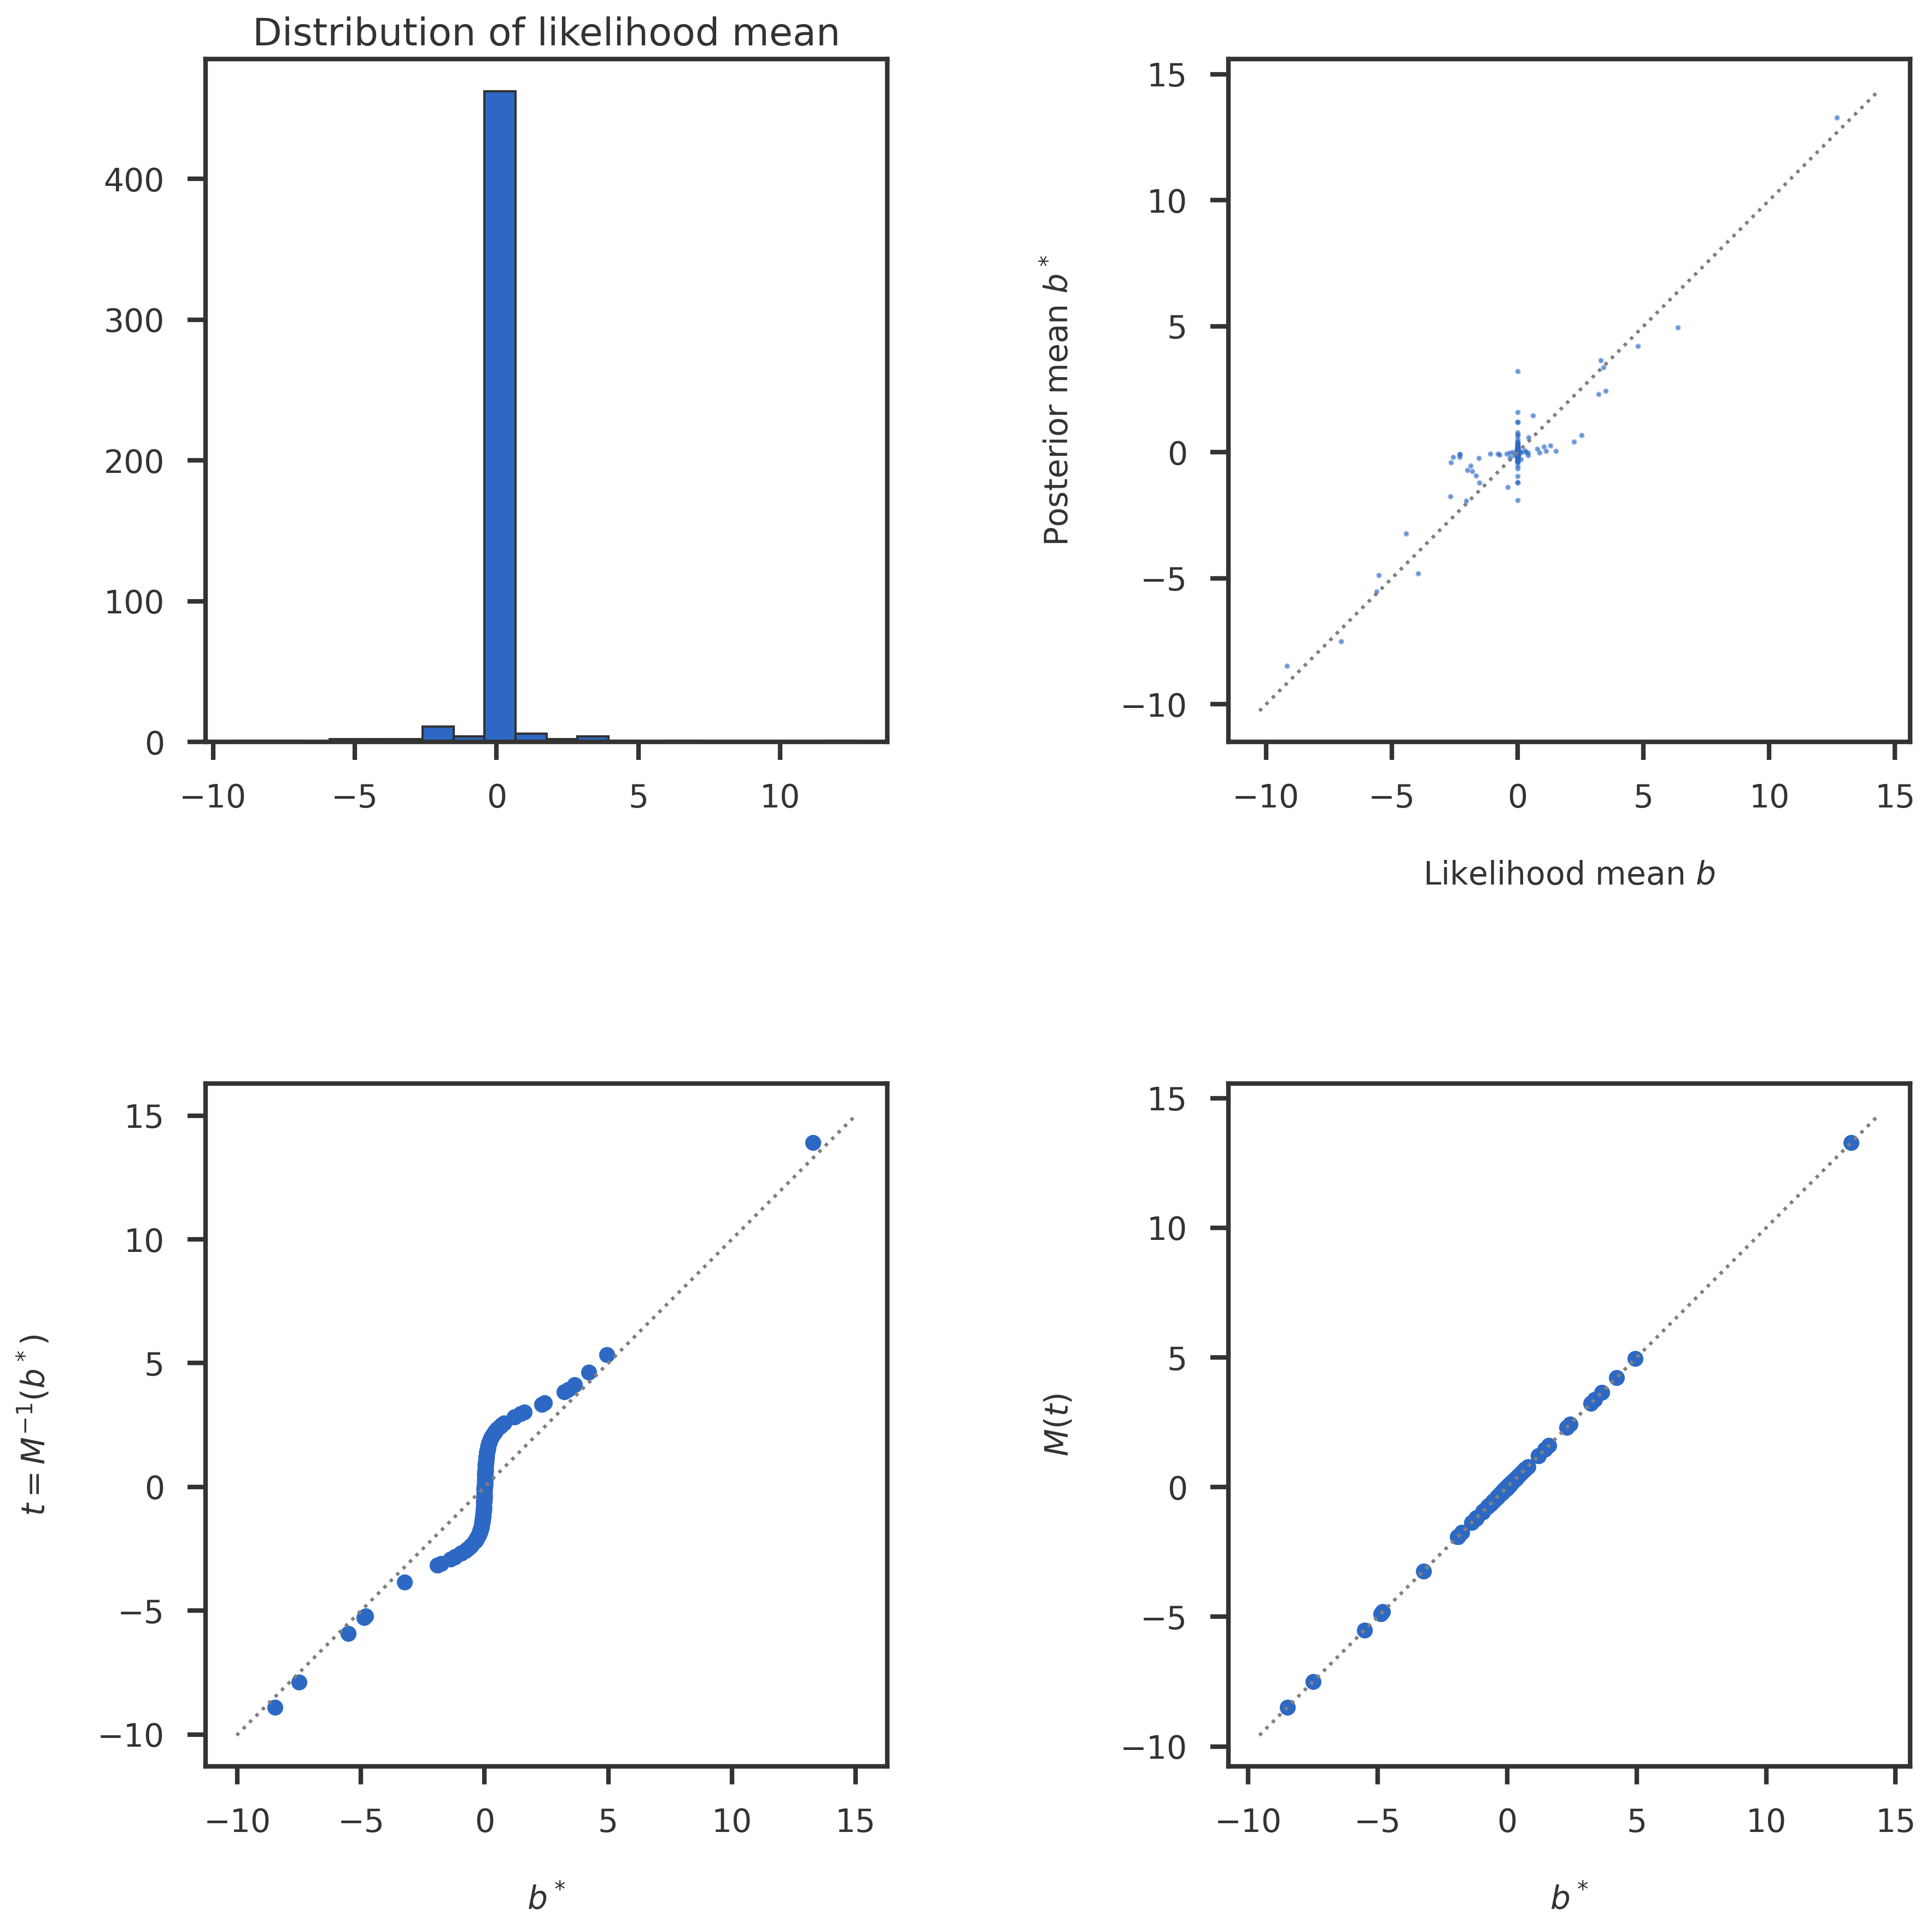

In [5]:
fig = plt.figure(figsize = (12, 12))
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
ax3 = fig.add_subplot(223)
ax4 = fig.add_subplot(224)
ax1.hist(btrue)
ax1.set_title("Distribution of likelihood mean")

ax2.scatter(btrue, bpostmean, s=2, alpha = 0.5)
mpl_utils.plot_diag(ax2)
ax2.set_xlabel(r"Likelihood mean $b$")
ax2.set_ylabel(r"Posterior mean $b^*$")
#ax1.hist(mean)

ax3.scatter(bconst, theta_newraph)
#ax3.scatter(theta_newraph, bconst)
mpl_utils.plot_diag(ax3)
ax3.set_xlabel(r"$b^*$")
ax3.set_ylabel(r"$t = M^{-1}(b^*)$")

ax4.scatter(bconst, b_newraph)
mpl_utils.plot_diag(ax4)
ax4.set_xlabel(r"$b^*$")
#ax4.set_ylabel(r"$M(M^{-1}(b^*))$")
ax4.set_ylabel(r"$M(t)$")

plt.tight_layout()
plt.subplots_adjust(wspace = 0.5, hspace = 0.5)
plt.show()

### Powell's Method

In [6]:
def powell_root_func(z, b, std, wk, sk, dj):
    return lgopt.shrink_theta(z, std, wk, sk, dj) - b

theta_init = np.zeros(p)
powell_opt = sp_optimize.root(powell_root_func, theta_init, 
                              args = (bconst, strue, wpost, sk, dj),
                              method = 'hybr', jac = None, tol = 1e-8
                             )
t_powell = powell_opt.x

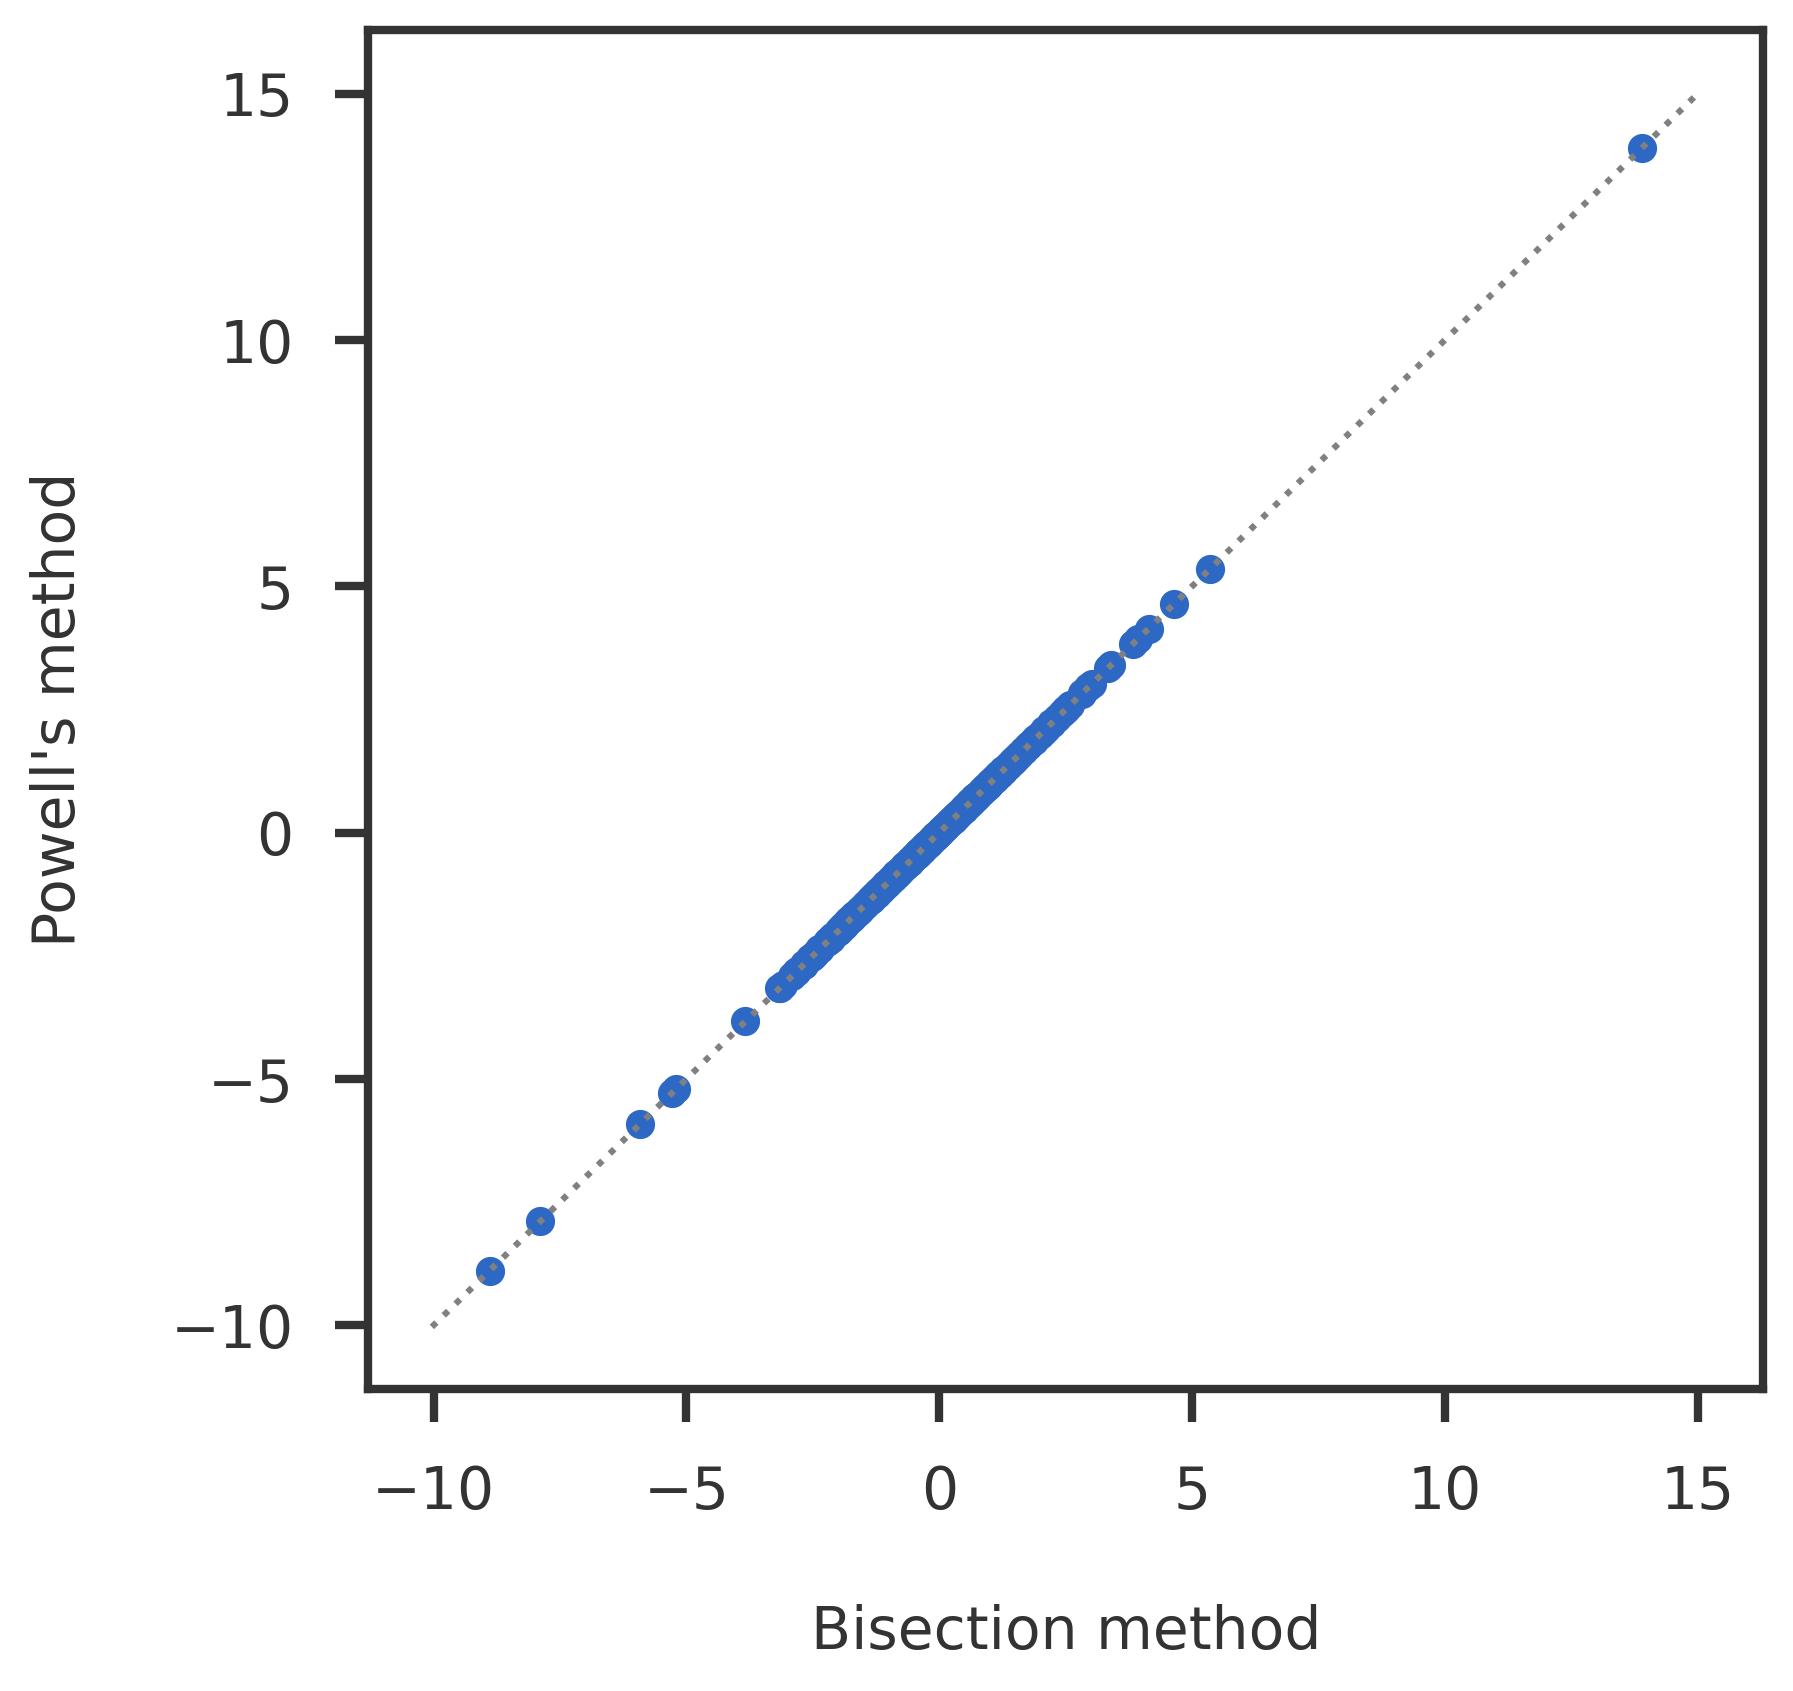

In [7]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(theta_newraph, t_powell)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("Bisection method")
ax1.set_ylabel ("Powell's method")
plt.show()

### FSSI

In [8]:
ngrid = 500
ymax = max(np.abs(bconst))
Minv = lgopt.shrinkage_operator_inverse(np.array([ymax]), strue, wpost, sk, np.ones(1), method = 'hybr')
xmax = Minv.x[0]
xposgrid = np.logspace(-4, np.log10(xmax), ngrid)
yposgrid, xderiv, _, _ = lgopt.shrinkage_operator(xposgrid, strue, wpost, sk, np.ones(ngrid), jac = True)
dposgrid = 1 / xderiv
xgrid = np.concatenate((-xposgrid[::-1], xposgrid))
ygrid = np.concatenate((-yposgrid[::-1], yposgrid))
dgrid = np.concatenate((-dposgrid[::-1], dposgrid))

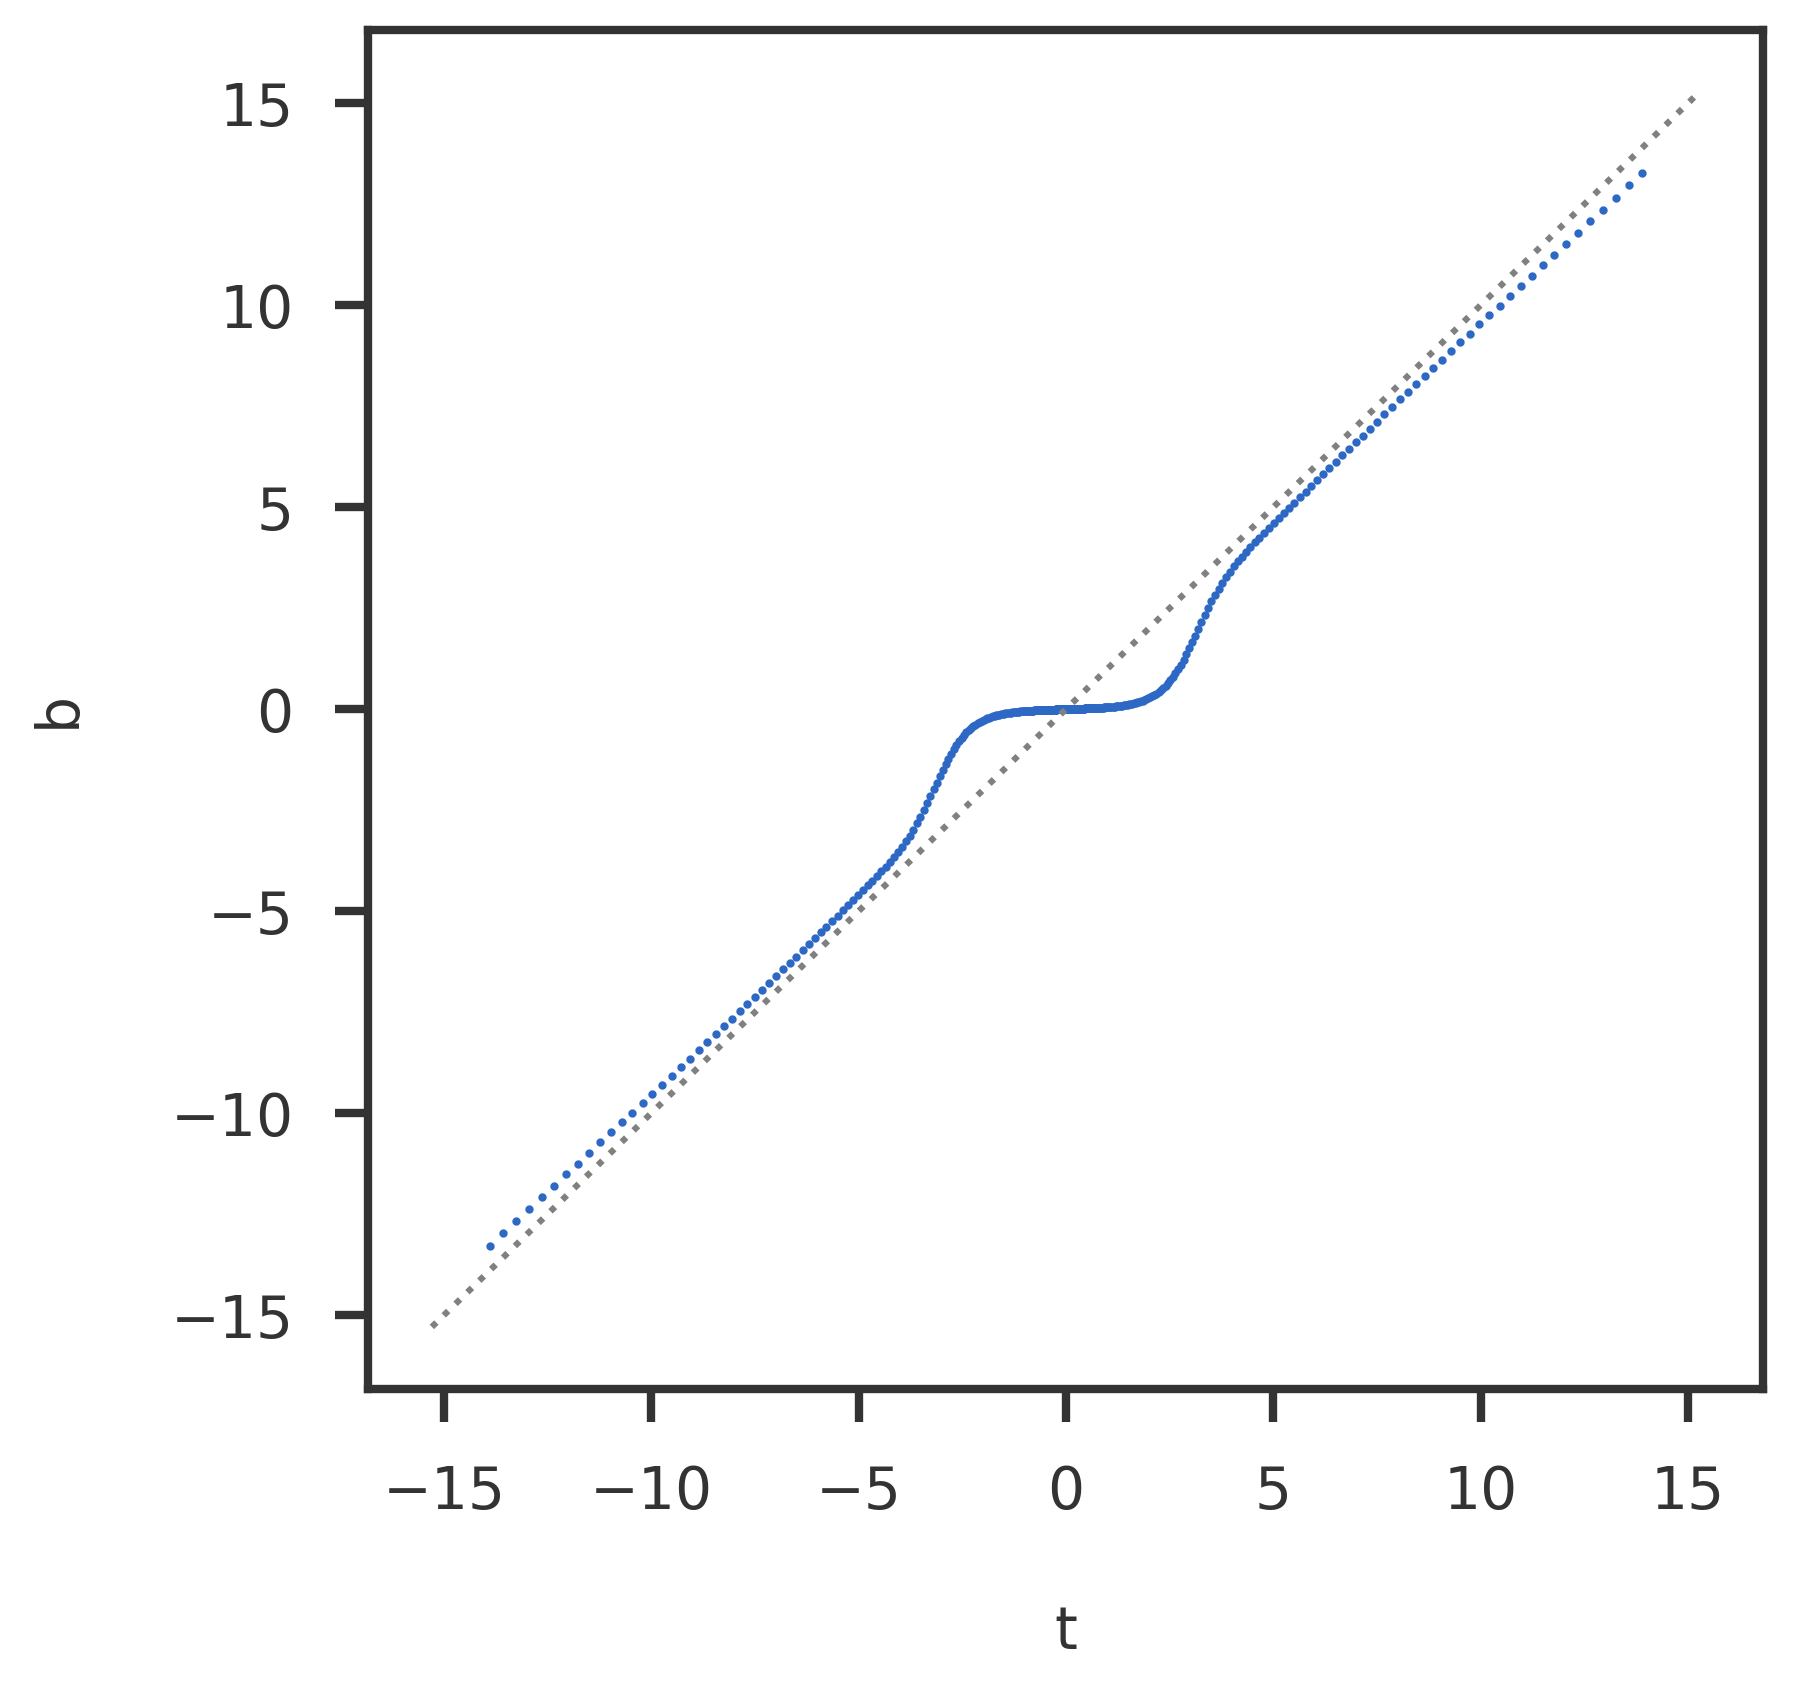

In [9]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(xgrid, ygrid, s = 1)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("t")
ax1.set_ylabel ("b")
plt.show()

In [10]:
t_fssi1 = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'fssi-linear', ngrid = 500).x
t_fssi3 = lgopt.shrinkage_operator_inverse(bconst, strue, wpost, sk, dj, method = 'fssi-cubic', ngrid = 500).x

b_fssi1 = lgopt.shrink_theta(t_fssi1, strue, wpost, sk, dj)
b_fssi3 = lgopt.shrink_theta(t_fssi3, strue, wpost, sk, dj)

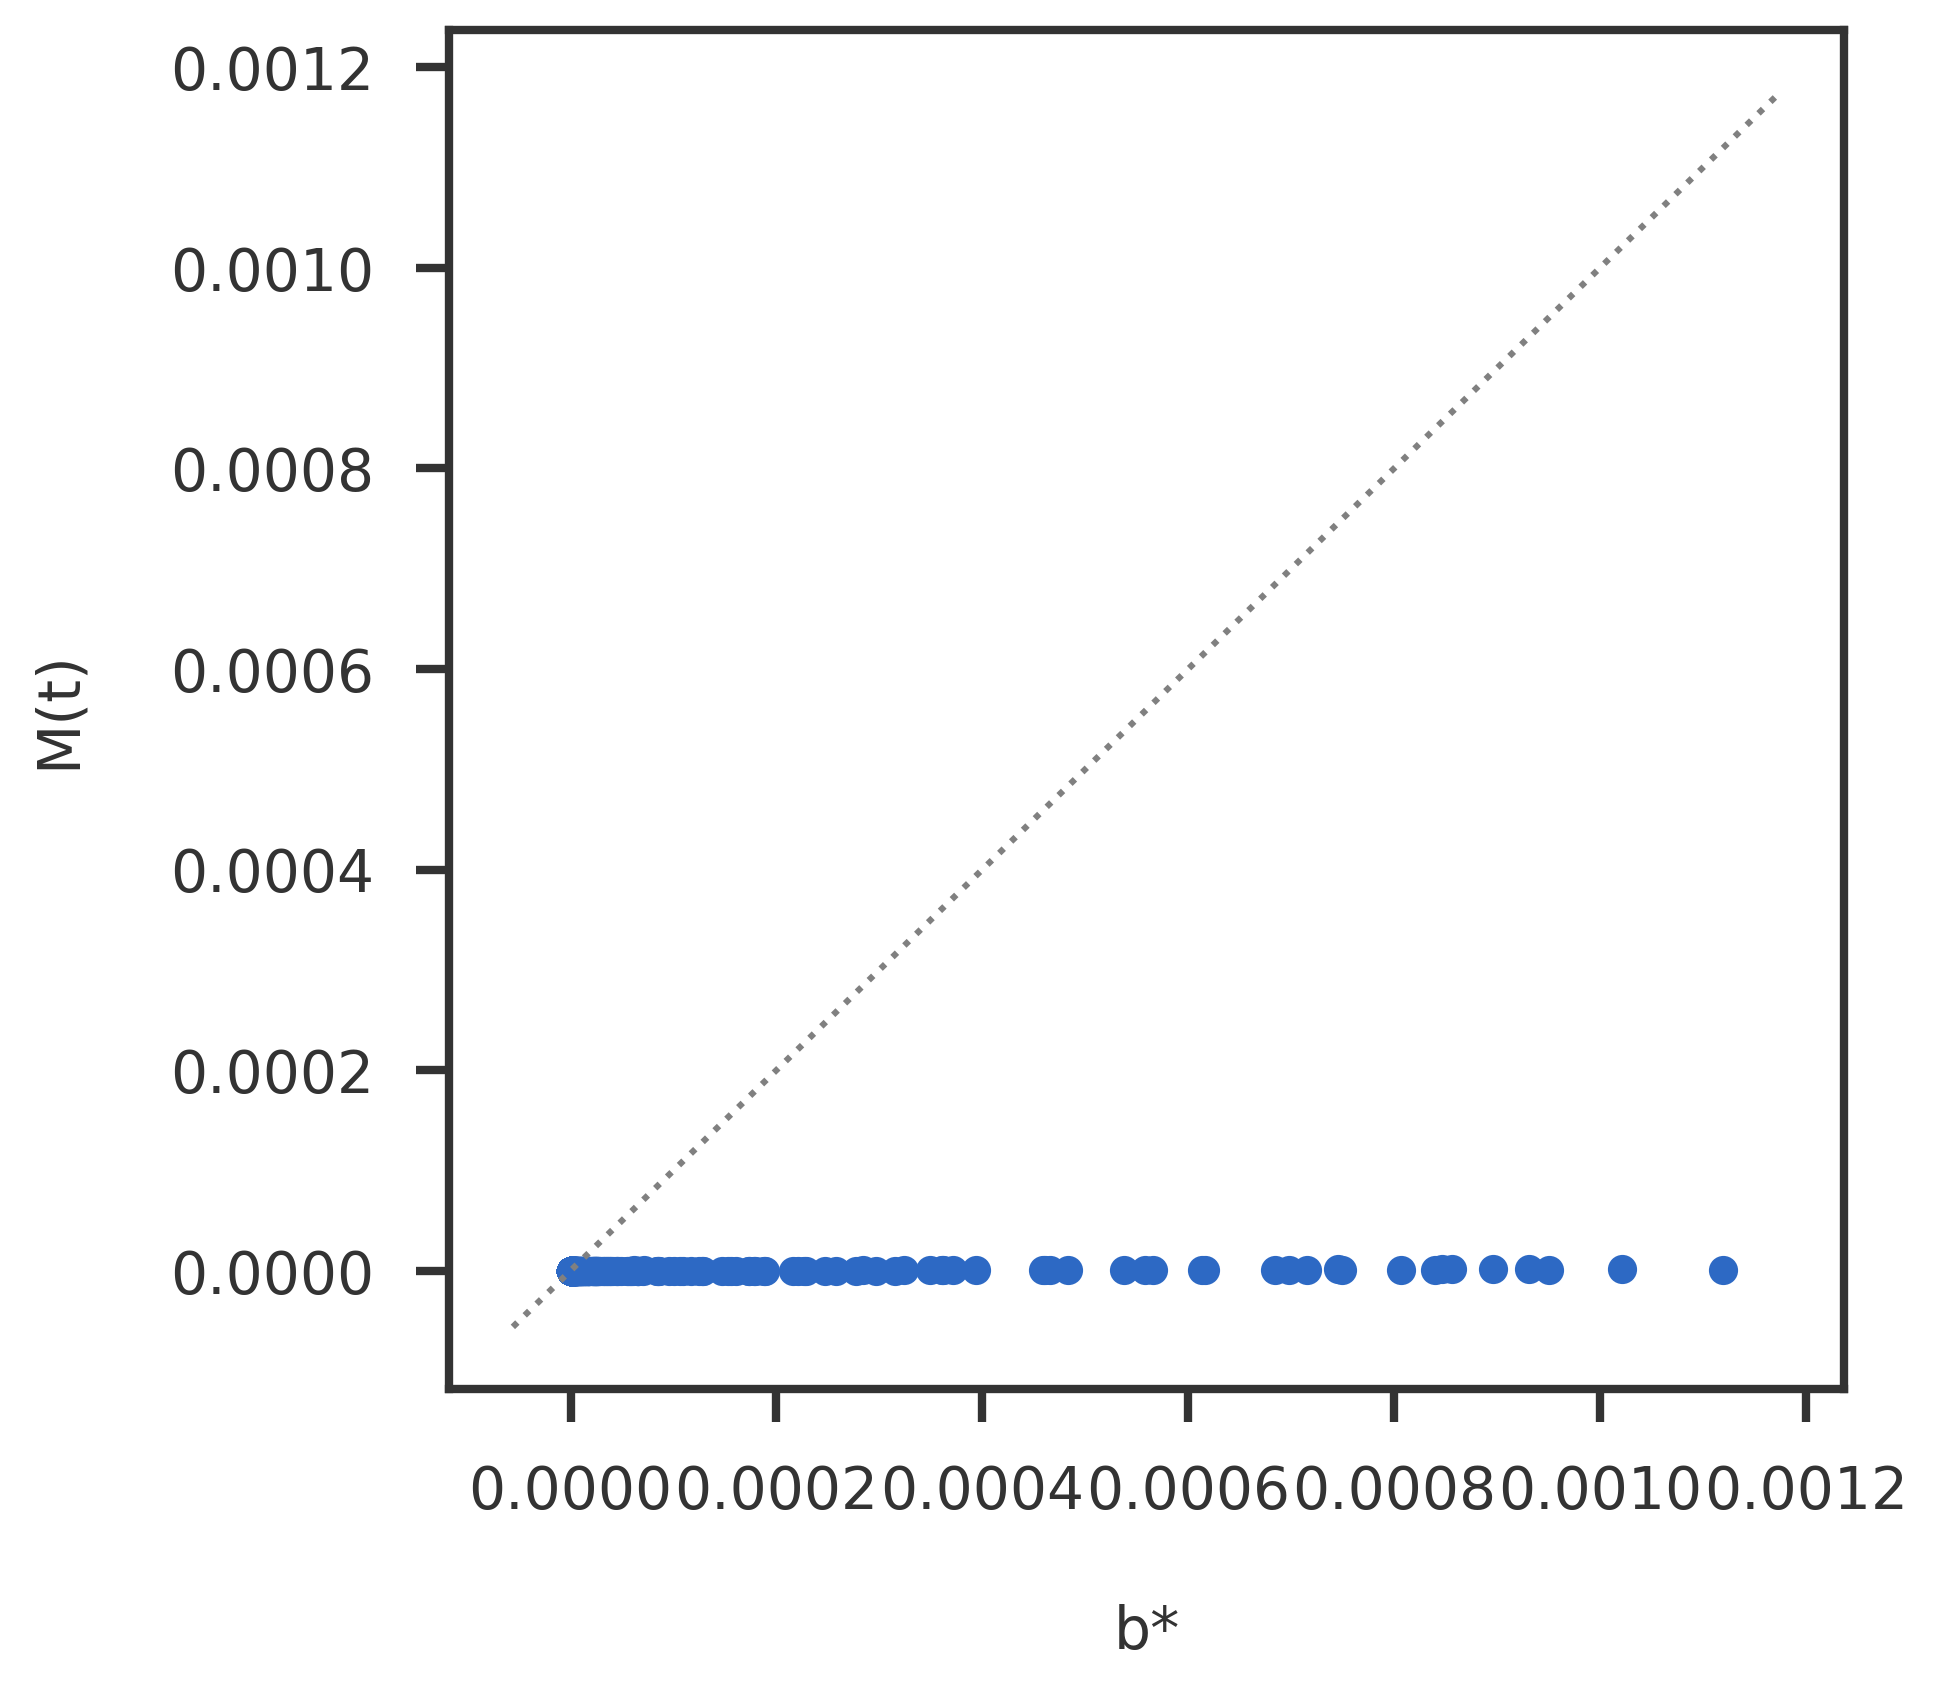

In [11]:
fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(np.abs(b_fssi1 - bconst), np.abs(b_fssi3 - bconst))
#ax1.scatter(bconst, b_fssi3)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("b*")
ax1.set_ylabel ("M(t)")
plt.show()

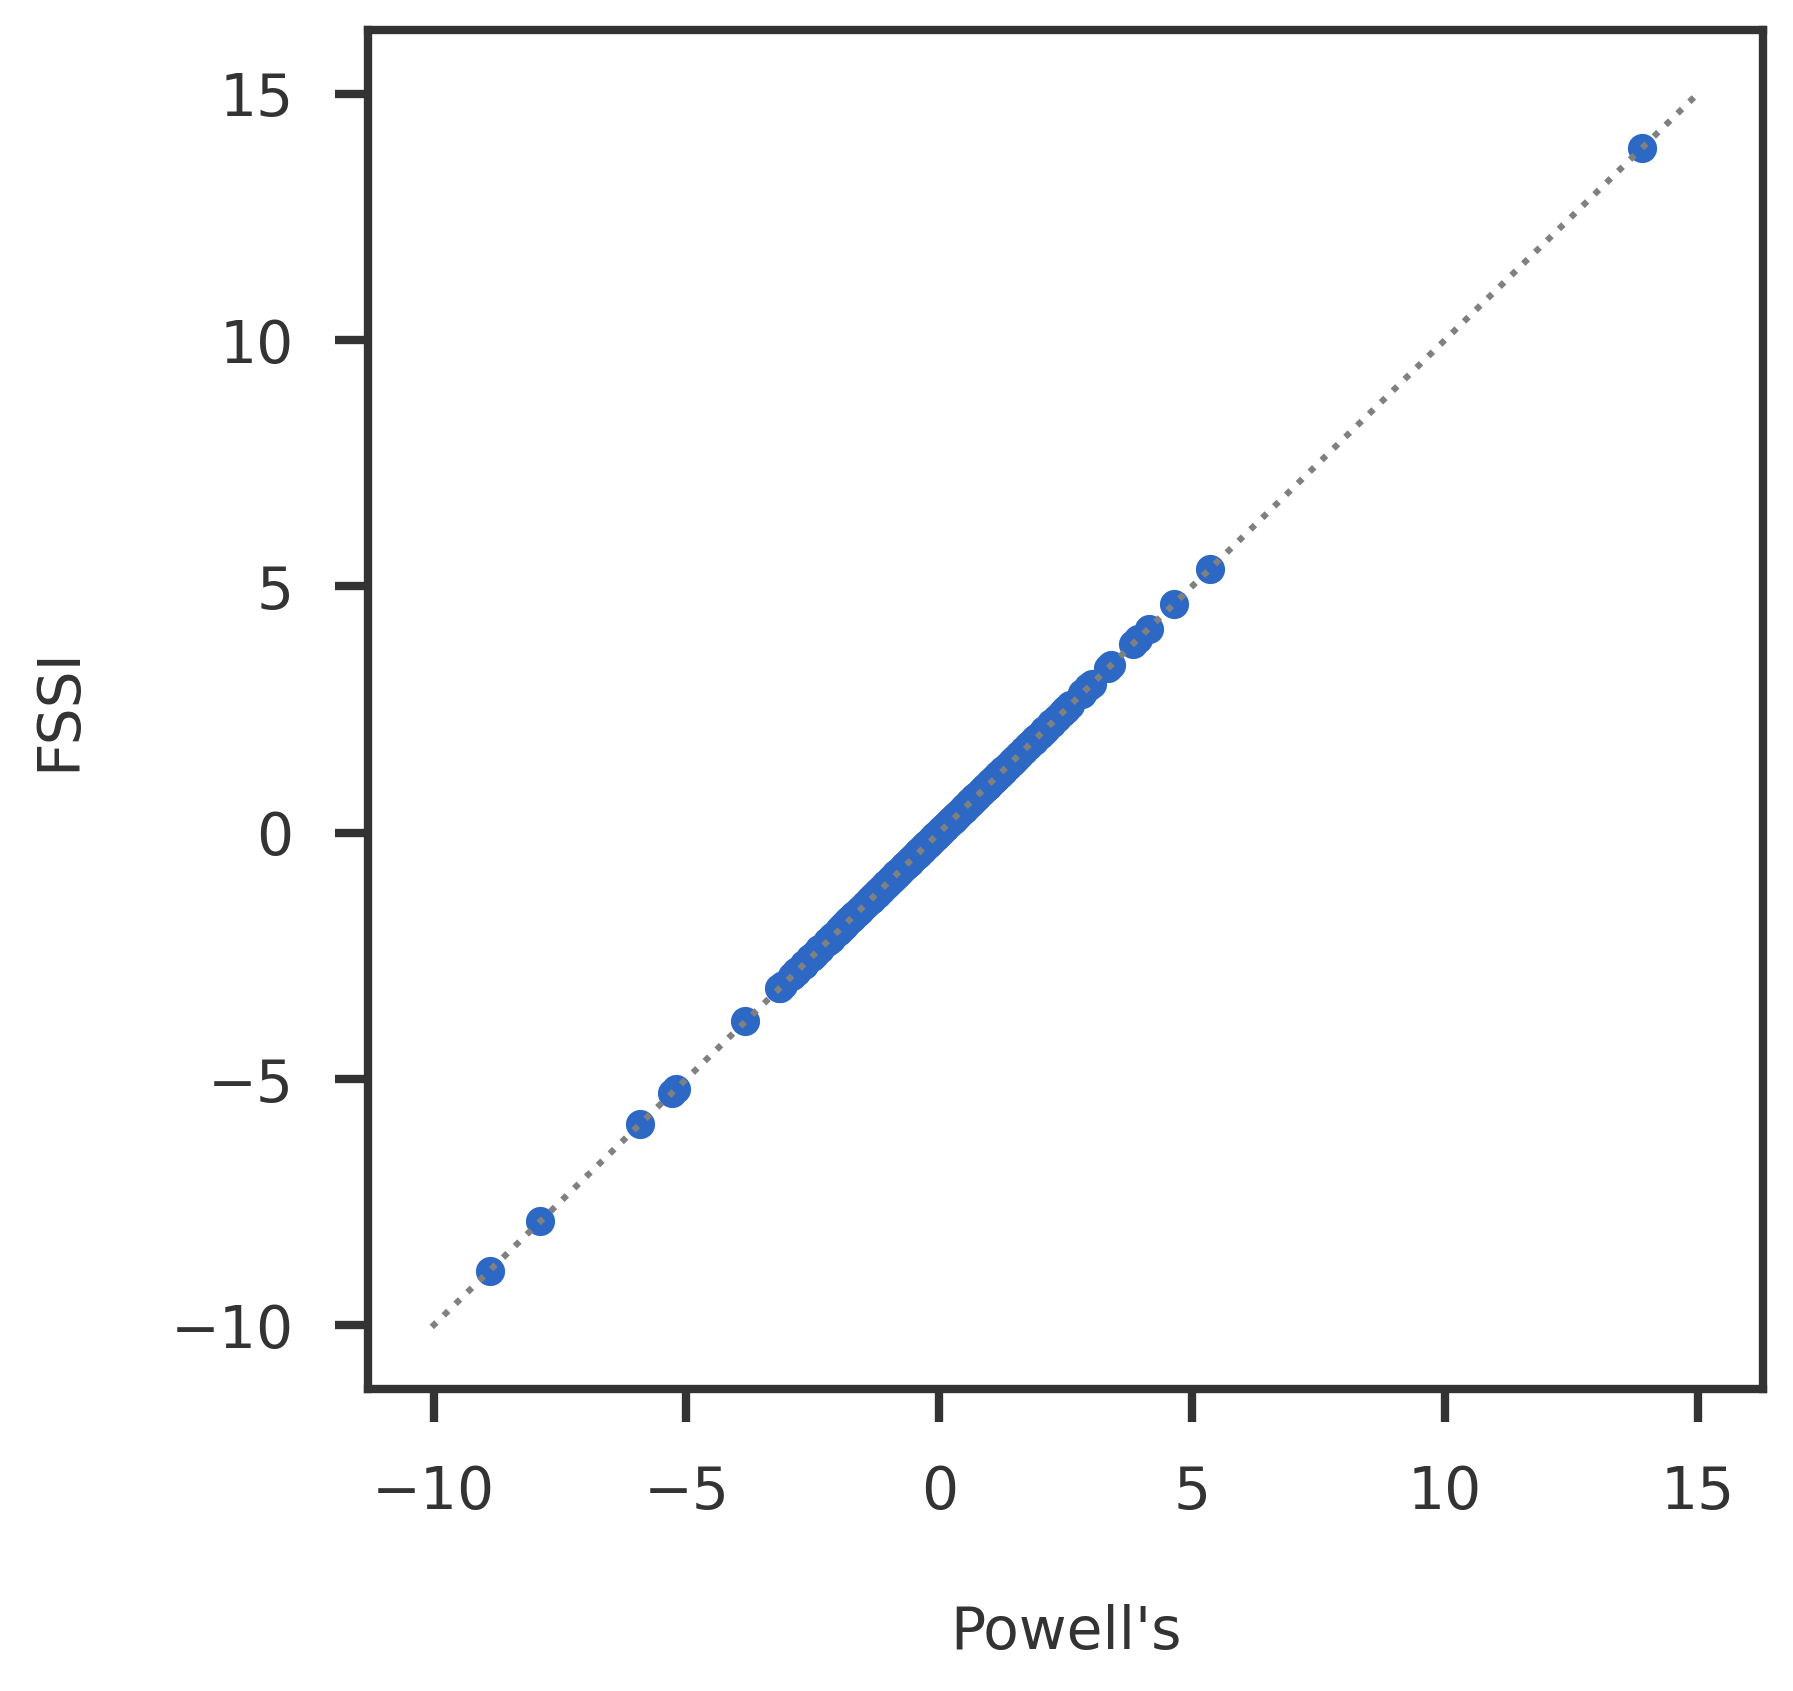

In [14]:
# def create_spline(y, yp, x, h):
#     """Create a cubic spline given values and derivatives.
#     Formulas for the coefficients are taken from interpolate.CubicSpline.
#     Returns
#     -------
#     sol : PPoly
#         Constructed spline as a PPoly instance.
#     """
#     from scipy.interpolate import PPoly

#     n, m = y.shape
#     c = np.empty((4, n, m - 1), dtype=y.dtype)
#     slope = (y[:, 1:] - y[:, :-1]) / h
#     t = (yp[:, :-1] + yp[:, 1:] - 2 * slope) / h
#     c[0] = t / h
#     c[1] = (slope - yp[:, :-1]) / h - t
#     c[2] = yp[:, :-1]
#     c[3] = y[:, :-1]
#     c = np.moveaxis(c, 1, 0)

#     return PPoly(c, x, extrapolate=True, axis=1)


# def create_spline(x, y, dydx):
#     n = y.shape[0]
#     dxr = np.diff(x)
#     c = np.empty((4, n - 1), dtype=y.dtype)
#     slope = (y[1:] - y[:-1]) / dxr
#     t = (dydx[:-1] + dydx[1:] - 2 * slope) / dxr
#     c[0] = t / dxr
#     c[1] = (slope - dydx[:-1]) / dxr - t
#     c[2] = dydx[:-1]
#     c[3] = y[:-1]
#     c = np.moveaxis(c, 1, 0)

#     return sp_interpolate.PPoly(c, x, extrapolate=True, axis=1)

def Minverse_fssi(b, std, wk, sk, ngrid = 50, interpolate = 'linear'):

    def create_spline(x, y, dydx):
        n = x.shape[0]
        c = np.empty((4, n-1), dtype = y.dtype)
        xdiff = np.diff(x)
        slope = (y[1:] - y[:-1]) / xdiff
        t = (dydx[:-1] + dydx[1:] - 2 * slope) / xdiff
        c[0] = t / xdiff
        c[1] = (slope - dydx[:-1]) / xdiff - t 
        c[2] = dydx[:-1]
        c[3] = y[:-1]
        return sp_interpolate.PPoly(c, x)

    babs = np.abs(b)
    ymax = max(babs)
    Minv = lgopt.shrinkage_operator_inverse(np.array([ymax]), std, wk, sk, np.ones(1), method = 'hybr')
    xmax = Minv.x[0]
    xgrid = np.logspace(-4, np.log10(xmax), ngrid)
    ygrid, xderiv, _, _ = lgopt.shrinkage_operator(xgrid, std, wk, sk, np.ones(ngrid), jac = True)
    dgrid = 1 / xderiv
    #xposgrid = np.logspace(-4, np.log10(xmax), ngrid)
    #print (f"Max values of b and M^{-1}(b) are {ymax}, {xmax}")
    #yposgrid = shrink_theta(xposgrid, std, wk, sk, np.ones(ngrid))
    #yposgrid, xderiv, _, _ = shrinkage_operator(xposgrid, std, wk, sk, np.ones(ngrid), jac = True)
    #dposgrid = 1 / xderiv
    #xgrid = np.concatenate((-xposgrid[::-1], xposgrid))
    #ygrid = np.concatenate((-yposgrid[::-1], yposgrid))
    #dgrid = np.concatenate((-dposgrid[::-1], dposgrid))
    if interpolate == 'linear':
        t_fssi = np.interp(babs, ygrid, xgrid)
        t_fssi *= np.sign(b)
    elif interpolate == 'cubic':
        cs = create_spline(ygrid, xgrid, dgrid)
        t_fssi = cs(babs)
        t_fssi *= np.sign(b)
    return t_fssi

t_fssi3 = Minverse_fssi(bconst, strue, wpost, sk, ngrid = 50000, interpolate = 'cubic')

fig = plt.figure(figsize=(6,6))
ax1 = fig.add_subplot(111)
ax1.scatter(theta_newraph, t_fssi3)
mpl_utils.plot_diag(ax1)
ax1.set_xlabel ("Powell's")
ax1.set_ylabel ("FSSI")
plt.show()